In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import subprocess as sp
%matplotlib inline

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

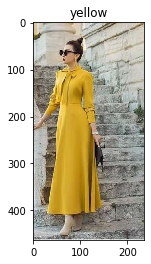

(463, 236, 3)
(463, 236)


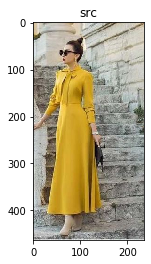

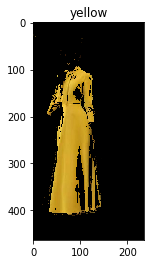

(463, 472, 3)


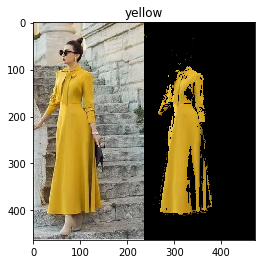

In [2]:
yellow = cv2.imread('yellow.jpg')
imshow("yellow", yellow )   
    
hsv = cv2.cvtColor(yellow, cv2.COLOR_BGR2HSV)
print(hsv.shape)
h = hsv[:,:,0]
s = hsv[:,:,1]
print(h.shape)    
    
dest = yellow.copy()
for r in range(yellow.shape[0]) :
    for c in range(yellow.shape[1]) :
        if h[r,c] >= 10 and h[r,c] <= 50 and   s[r,c] >= 170 and s[r,c] <= 230 : 
            dest[r,c, :] =  yellow[r,c,:]  #[255,255,255]
        else :
            dest[r,c, :] = [0,0,0]         
imshow("src", yellow)
imshow("yellow", dest)

dest2 = np.hstack((yellow, dest ))
print(dest2.shape)
imshow("yellow", dest2)   

In [ ]:
def chromakey(img) :    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    patch = hsv[0:20, 0:20, :]
    minH = np.min(patch[:,:,0])*0.9
    maxH = np.max(patch[:,:,0])*1.1
    minS = np.min(patch[:,:,1])*0.9
    maxS = np.max(patch[:,:,1])*1.1
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    dest = img.copy()
    for r in range(img.shape[0]) :
        for c in range(img.shape[1]) :
            if h[r,c] >= minH and h[r,c] <= maxH and   s[r,c] >= minS  and s[r,c] <= maxS : 
                dest[r,c, :] = [0,0,0]         
            else :
                dest[r,c, :] =  img[r,c,:]
    return dest            

In [ ]:
cap = cv2.VideoCapture('dance.mp4')

for i in range(25*6) : 
        ret, frame = cap.read()
        frame = cv2.resize(frame, dsize=(320,240)) 
                        
        dest = chromakey(frame)
        
        dest = np.hstack((frame, dest))
        cv2.imshow('frame', dest)        
        
        if cv2.waitKey(10) == 27:
            break

cv2.destroyAllWindows()

In [ ]:
def chromakey(img, background) :    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    patch = hsv[0:20, 0:20, :]
    minH = np.min(patch[:,:,0])*0.9
    maxH = np.max(patch[:,:,0])*1.1
    minS = np.min(patch[:,:,1])*0.9
    maxS = np.max(patch[:,:,1])*1.1
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    dest = img.copy()
    for r in range(img.shape[0]) :
        for c in range(img.shape[1]) :
            if h[r,c] >= minH and h[r,c] <= maxH and   s[r,c] >= minS  and s[r,c] <= maxS : 
                dest[r,c, :] = background[r,c,:]
            else :
                dest[r,c, :] =  img[r,c,:]
    return dest            



In [ ]:
%%writefile server.py

import cv2
import numpy as np
from flask import Flask, request
import datetime

app = Flask(__name__)

def chromakey(img, background) :    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    patch = hsv[0:20, 0:20, :]
    minH = np.min(patch[:,:,0])*0.9
    maxH = np.max(patch[:,:,0])*1.1
    minS = np.min(patch[:,:,1])*0.9
    maxS = np.max(patch[:,:,1])*1.1
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    dest = img.copy()
    for r in range(img.shape[0]) :
        for c in range(img.shape[1]) :
            if h[r,c] >= minH and h[r,c] <= maxH and   s[r,c] >= minS  and s[r,c] <= maxS : 
                dest[r,c, :] = background[r,c,:]
            else :
                dest[r,c, :] =  img[r,c,:]
    return dest            

@app.route('/') 
def index():
    html = """    
       <form action=/upload method=post enctype="multipart/form-data">
          <input type=file name=file1> <input type=submit value="전송">          
       </form>
    """    
    return html
    
@app.route('/upload', methods=["post"])
def upload():
    f = request.files['file1']   
    filename = "./static/" + f.filename
    f.save(filename)       
     
    img = cv2.imread(filename)
    img = cv2.resize(img, dsize=(320,240))     
    
    background = cv2.imread('background.jpg')
    background = cv2.resize(background, dsize=(320,240)) 

    img = chromakey(img, background)    
    cv2.imwrite(filename, img)    
    
    return "<img src=/static/"  + f.filename + "?" + datetime.datetime.now().strftime('%H%M%S') + ">"
    
if __name__ == '__main__':
     app.run(host='0.0.0.0', debug=True, port=8000)      